# Exploratory Data Analysis

In [1]:
import warnings

warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import heapq

from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer

from eda.token_frequency_analyzer import TokenFrequencyAnalyzer
from preprocessing.cleaning.text_cleaning import process_text, process_text_tokens
from preprocessing.cleaning.data_process import process_date

%load_ext autoreload
%autoreload 2

In [3]:
init_df = pd.read_csv("../data/raw/fake_news_full_data.csv")

In [4]:
init_df.head(5)

,Unnamed: 0,title,text,date,is_fake
0,0,Earthquake hits off Papua New Guinea,LONDON (Reuters) - A magnitude 5.9 earthquake ...,"September 17, 2017",0
1,1,CINDY MCCAIN Reportedly Accepts Trump Administ...,The Hill released controversial comments sore ...,"Jun 12, 2017",1
2,2,Prosecutors say ex-House Speaker Hastert sexua...,(Reuters) - Former U.S. House Speaker Dennis H...,"April 9, 2016",0
3,3,Romanian protesters halt building of Xmas fair...,BUCHAREST (Reuters) - Romanian protesters clas...,"December 2, 2017",0
4,4,"Congo elected to U.N. rights council; Britain,...",UNITED NATIONS (Reuters) - Democratic Republic...,"October 16, 2017",0


In [5]:
df = init_df.copy()

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44680 entries, 0 to 44679
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  44680 non-null  int64 
 1   title       44680 non-null  object
 2   text        44680 non-null  object
 3   date        44680 non-null  object
 4   is_fake     44680 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 1.7+ MB


Спостереження: Бачимо, що ознака date - має тип object, що маємо врахувати та обробити.

In [7]:
df.isnull().sum()

Unnamed: 0    0
title         0
text          0
date          0
is_fake       0
dtype: int64

Спостереження: Набір даних не має пропущених значень.

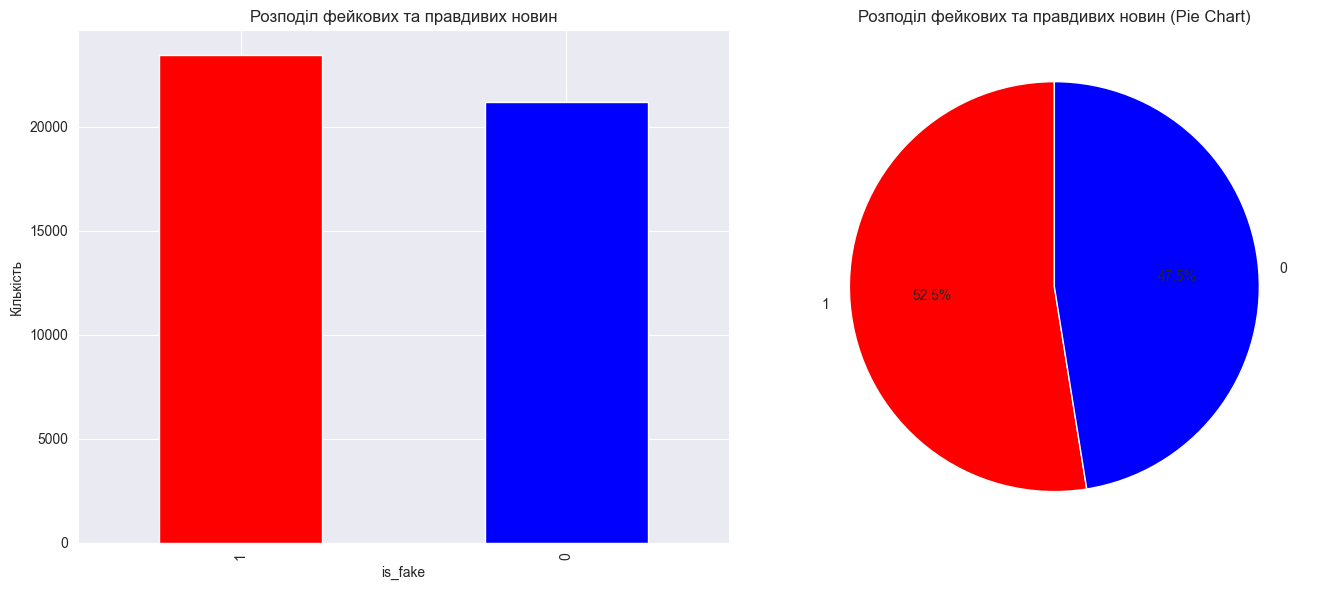

is_fake
1    23469
0    21211
Name: count, dtype: int64

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

df['is_fake'].value_counts().plot(kind='bar', ax=axes[0], color=['red', 'blue'])
axes[0].set_title('Розподіл фейкових та правдивих новин')
axes[0].set_xlabel('is_fake')
axes[0].set_ylabel('Кількість')

df['is_fake'].value_counts().plot(kind='pie', ax=axes[1], autopct='%1.1f%%', colors=['red', 'blue'], startangle=90)
axes[1].set_title('Розподіл фейкових та правдивих новин (Pie Chart)')
axes[1].set_ylabel('')

plt.tight_layout()
plt.show()

df['is_fake'].value_counts()

Спостереження: Маємо гарно збалансовані класи, їх розділ майже рівномірний. Отже, непотрібно вживати радикальних заходів щодо балансування oversampling або undersampling.

## Продивимось декілька екземплярів кожного з класів вручну

#### Фейкові новини

In [9]:
fake_news = df[df["is_fake"] == 1].head(3)
for i, row in fake_news.iterrows():
    print(f"\n\tЗаголовок: {row['title']}")
    print(f"Текст: {row['text']}")


	Заголовок: CINDY MCCAIN Reportedly Accepts Trump Administration Position On Same Day Husband John McCain’s Outrageous Pro-Obama, Anti-Trump Remarks Are Released
Текст: The Hill released controversial comments sore loser and RINO Senator John McCain made about Trump s leadership:Sen. John McCain (R-Ariz.) said American leadership was stronger under President Trump s predecessor, President Barack Obama, according to a Guardian report published Sunday.Asked if the country stood on sturdier ground under Obama s leadership, McCain said  yes,  according to the report. As far as American leadership is concerned, yes,  said McCain, who also vocally criticized many of the Obama administration s foreign policy decisions.For months, President Donald Trump has been trying to convince Cindy McCain a respected voice on refugees and other humanitarian issues and wife of Sen. John McCain, a Trump critic to join his administration. Now, it s a  done deal  for both parties, according to two senior adm

#### Реальні новини

In [10]:
fake_news = df[df["is_fake"] == 0].head(3)
for i, row in fake_news.iterrows():
    print(f"\n\tЗаголовок: {row['title']}")
    print(f"Текст: {row['text']}")


	Заголовок: Earthquake hits off Papua New Guinea
Текст: LONDON (Reuters) - A magnitude 5.9 earthquake hit off the coast of Papua New Guinea in the early hours of Monday local time, the Pacific Tsunami Warning Center said. The quake struck at a depth of 37 km (23 miles), in the sea southwest of Kandrian soon after midnight (1426 GMT Sunday), the center added. 

	Заголовок: Prosecutors say ex-House Speaker Hastert sexually abused boys
Текст: (Reuters) - Former U.S. House Speaker Dennis Hastert, convicted last year of a financial crime in a hush-money case, had agreed to pay $3.5 million to buy the silence of an individual who he sexually abused when the victim was a teenager, federal prosecutors said on Friday. It was the first time that prosecutors, in a new court filing, had said that Hastert had been extorted to keep quiet allegations he sexually abused a 14-year-old victim decades ago. In the filing the prosecutors accuse Hastert, 74, of molesting several boys when he was a high sch

Спостереження:

У фейкових новинах часто використовується мова, яка викликає сильні емоції — обурення, страх, зневагу. Фейки часто починаються із заголовків, які апелюють до скандалу, змови чи “шокуючого викриття”. У них використовуються гучні теми. Тоді як реальні новини характеризуються зваженим, об’єктивним стилем. У тексті немає різко емоційної лексики або оцінних суджень. Висвітлення подій є зосередженим на фактах, а не на реакціях читачів.

## Аналіз довжин

In [11]:
df['title_length'] = df['title'].apply(len)
df['text_length'] = df['text'].apply(len)

In [12]:
print(df[['title_length', 'text_length']].describe())

       title_length   text_length
count  44680.000000  44680.000000
mean      80.173523   2467.577686
std       25.406694   2173.569143
min        8.000000      1.000000
25%       63.000000   1233.000000
50%       73.000000   2185.000000
75%       91.000000   3101.250000
max      286.000000  51794.000000


Спостереження: Розрахувавши довжини заголовків і текстів можемо отримати уявлення про характер вмісту документів та варіативність обсягів інформації у фейкових і нефейкових публікаціях.

- Заголовки новин мають довжину від 8 до 286 символів, з медіаною 73 символи, що вказує на компактність та стандартизованість. 75% заголовків мають довжину до 91 символа, а середнє значення — близько 80 символів. Можемо говорити про відносну однорідну структуру заголовків у вибірці.

- Довжина текстів значно варіюється — від 1 символа до понад 51 тисячі. Медіана становить 2,185 символів, а 75% документів містять до 3,101 символа.
- Середнє значення також досить високе — 2,467 символів, що говорить про наявність довгих статей.
- Велике стандартне відхилення (2173 символи) свідчить про значну дисперсію в обсягах текстів.


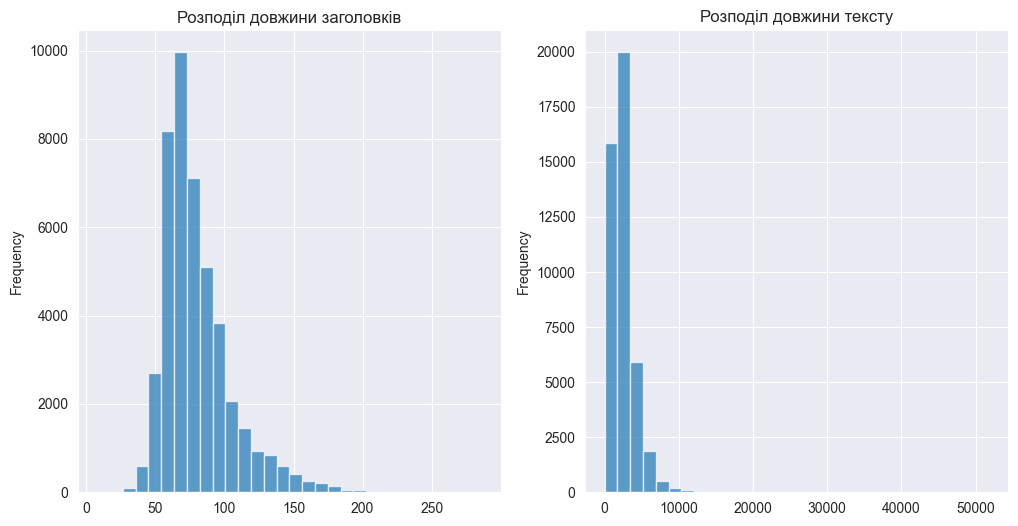

In [13]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
df['title_length'].plot(kind='hist', bins=30, alpha=0.7, title='Розподіл довжини заголовків')

plt.subplot(1, 2, 2)
df['text_length'].plot(kind='hist', bins=30, alpha=0.7, title='Розподіл довжини тексту')
plt.show()

Спостереження:

Розподіл довжини заголовків:
- Бачимо одномодальний розподіл, достатньо близбкий до нормального з невеликою асиметрією вправо.
- Більшість заголовків мають довжину від приблизно 50 до 110.
- Пік розподілу припадає приблизно на 70–90 символів, що відповідає медіанному значенню.
- Відхилення за межі 150 символів трапляються рідко, довжина заголовка понад 200 символів — виняток.

Розподіл довжини текстів:
- Розподіл сильно асиметричний, з довгим хвостом, що свідчить про наявність дуже довгих текстів.
- Основна маса документів має довжину до 5,000 символів, де спостерігається найвища концентрація.
- Трапляються документи з довжиною понад 10,000 символів, але це — рідкісні випадки. Пам'ятаємо, зі значень третього квартилю, що 75% документів містять до 3,101 символів.

### Порівняємо довжини заголовків і текстів між фейковими та справжніми новинами:

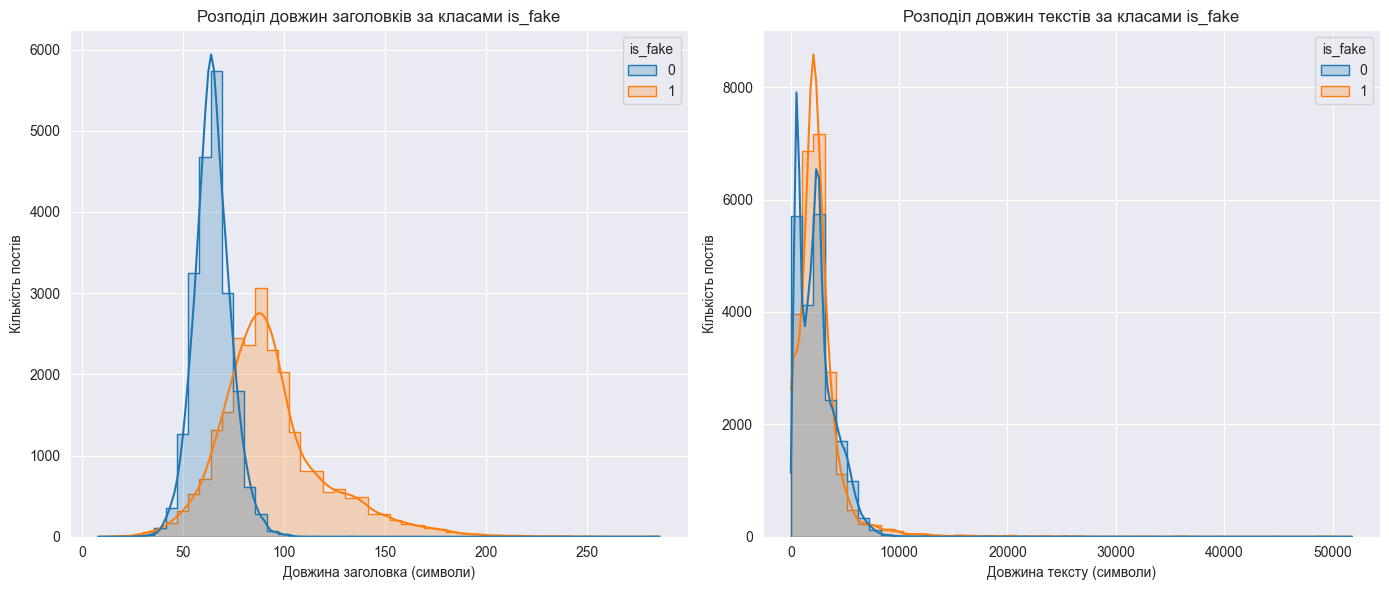

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.histplot(data=df, x='title_length', hue='is_fake', bins=50, kde=True, element="step")
plt.title('Розподіл довжин заголовків за класами is_fake')
plt.xlabel('Довжина заголовка (символи)')
plt.ylabel('Кількість постів')
plt.grid(True)

plt.subplot(1, 2, 2)
sns.histplot(data=df, x='text_length', hue='is_fake', bins=50, kde=True, element="step")
plt.title('Розподіл довжин текстів за класами is_fake')
plt.xlabel('Довжина тексту (символи)')
plt.ylabel('Кількість постів')
plt.grid(True)

plt.tight_layout()
plt.show()

Спостереження:

Заголовки:
- Бачимо, що новини мають коротші та більш стандартизовані заголовки. Їх пік знаходиться в діапазоні 60–70 символів.
- Фейкові новини натомість мають довші заголовки, з піком у районі 90 символів.
- Спостерігається зміщення розподілу вправо для фейкових новин, що може свідчити про прагнення до сенсаційності або клікбейту.

Тексти новин:
- Обидва класи мають схожий сильно асиметричний розподіл із довгим правим хвостом.
- Фейкові тексти здаються трохи довшими в середньому.

Можемо припускати, що фейкові новини схильні мати довші, більш варіативні заголовки й трохи більш розлогі тексти, а отже фейковий контент часто перенавантажений словами, аби здаватися переконливішим або драматичнішим.





#### Дослідимо детальніше довжини текстів новин

In [15]:
df.groupby("is_fake")["text_length"].describe()

,count,mean,std,min,25%,50%,75%,max
is_fake,,,,,,,,
0,21211.0,2378.042337,1684.467512,1.0,903.5,2216.0,3226.5,29781.0
1,23469.0,2548.498658,2533.026833,1.0,1433.0,2167.0,3032.0,51794.0


Спостереження:

- Середня довжина текстів фейкових новин трохи вища (2548 проти 2378 символів), що свідчить про загальну тенденцію до більш розлогого викладення.
- Розкид значень (std) у фейкових новин значно вищий — 2533 проти 1684, тобто фейкові новини мають більш варіативну довжину.
- Хоча медіана довжини в обох класах близька (~2200 символів), перший квартиль значно вищий для фейкових новин: 1433 проти 904. Це означає, що нижні 25% фейкових текстів довші, ніж у справжніх.
- Максимальна довжина серед фейкових новин майже вдвічі більша, ніж у справжніх.

Візуалізуємо Violinplot

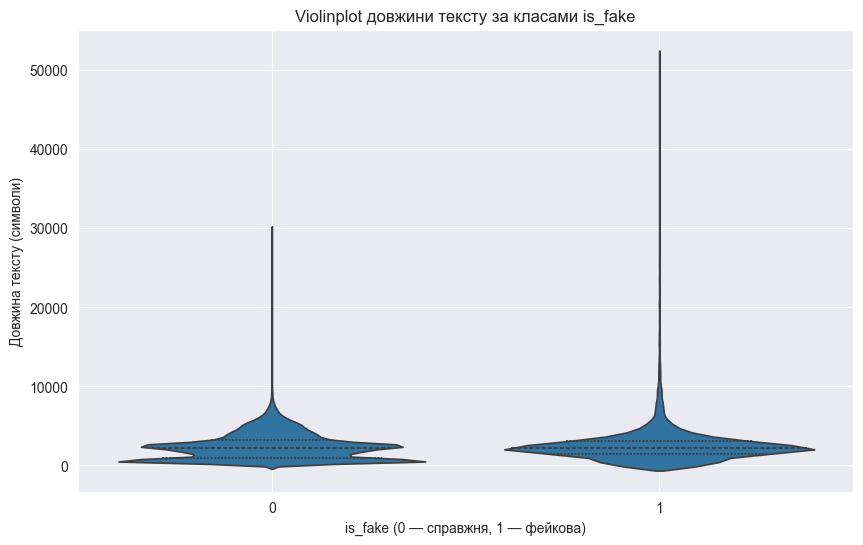

In [16]:
plt.figure(figsize=(10, 6))
sns.violinplot(data=df, x='is_fake', y='text_length', inner='quartile')
plt.title("Violinplot довжини тексту за класами is_fake")
plt.xlabel("is_fake (0 — справжня, 1 — фейкова)")
plt.ylabel("Довжина тексту (символи)")
plt.grid(True)
plt.show()

Спостереження:

- Бачимо, що для обох розподілів по класах маємо довгі "хвости".
- Довгі тексти (понад 10,000 символів) трапляються переважно у класі 1 — тобто серед фейкових новин.
- Основна маса значень сконцентрована в інтервалі приблизно 1000 – 5000 символів в обох класах, однак у фейкових новин розподіл пласкіший і ширший, що вказує на більшу варіативність.

##  Аналіз слів

Оцінимо довжини публікацій у токенах, виконавши попередню обробку тексту - лише очищення.

In [17]:
df["text_tokens"] = df["text"].apply(lambda x: process_text_tokens(x))
df["text_length_tokens"] = df["text_tokens"].apply(lambda x: len(x))

In [18]:
df["title_tokens"] = df["title"].apply(lambda x: process_text_tokens(x))
df["title_length_tokens"] = df["title_tokens"].apply(lambda x: len(x))

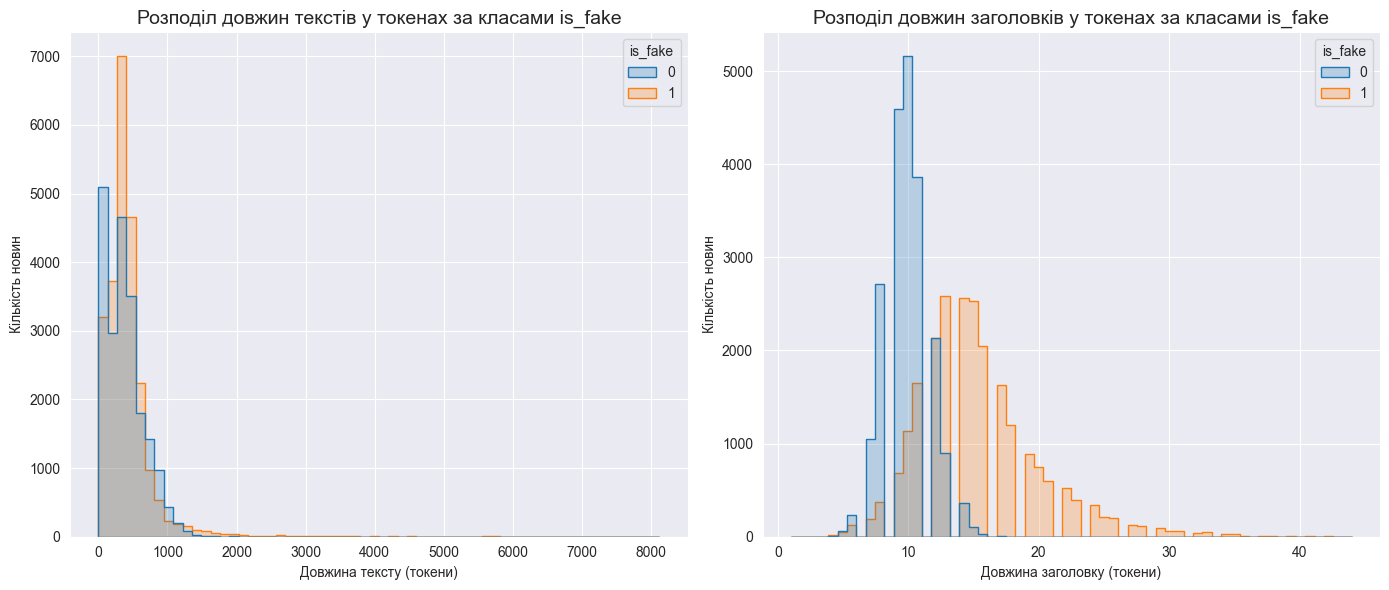

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.histplot(data=df, x="text_length_tokens", hue="is_fake", bins=60, kde=False, element='step', stat="count")
plt.title("Розподіл довжин текстів у токенах за класами is_fake", fontsize=14)
plt.xlabel("Довжина тексту (токени)")
plt.ylabel("Кількість новин")
plt.grid(True)

plt.subplot(1, 2, 2)
sns.histplot(data=df, x="title_length_tokens", hue="is_fake", bins=60, kde=False, element='step', stat="count")
plt.title("Розподіл довжин заголовків у токенах за класами is_fake", fontsize=14)
plt.xlabel("Довжина заголовку (токени)")
plt.ylabel("Кількість новин")
plt.grid(True)

plt.tight_layout()
plt.show()

Спостереження:
- Басимо, що основна маса текстів лежить до 1000 токенів, та має різкий спад після приблизно 500 токенів. Також можемо спостерігати довгий хвіст до 8000, що є аномаліями.
- Для заголовків основна частина лежить у діапазоні від 7 до 25 токенів. До того ж бачимо, що фейкові заголовки досить розтягнуті

Побудуємо попередньо хмари слів на даних, що маємо, окремо для фейкових та реальних новин (без очищення).

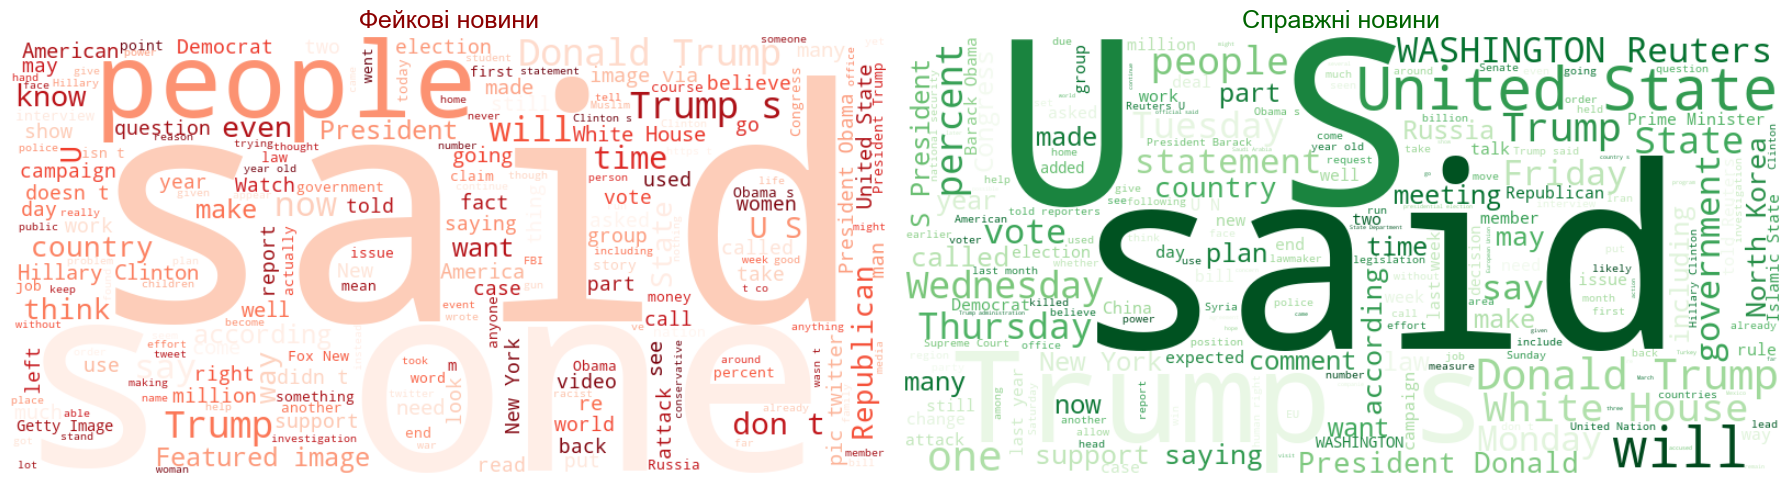

In [20]:
def generate_comparison_wordcloud(fake_text, real_text):
    fig, axes = plt.subplots(1, 2, figsize=(18, 8))

    wordcloud_fake = WordCloud(width=800, height=400, background_color='white',
                               colormap='Reds', max_words=200).generate(fake_text)
    axes[0].imshow(wordcloud_fake, interpolation='bilinear')
    axes[0].set_title('Фейкові новини', fontsize=18, color='darkred')
    axes[0].axis('off')

    wordcloud_real = WordCloud(width=800, height=400, background_color='white',
                               colormap='Greens', max_words=200).generate(real_text)
    axes[1].imshow(wordcloud_real, interpolation='bilinear')
    axes[1].set_title('Справжні новини', fontsize=18, color='darkgreen')
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()

# Підготовка текстів
fake_text = " ".join(df[df['is_fake'] == 1]['text'].astype(str))
real_text = " ".join(df[df['is_fake'] == 0]['text'].astype(str))

generate_comparison_wordcloud(fake_text, real_text)

Спостереження:
- Найпоширеніші слова присутні в обох класах: said, people, Trump, one, will, State, United, що в цілому очікувано для загальнополітичних новин.
- У фейкових новинах більше емоційних або неформальних слів: think, even, know і т.д.
- Також зустрічаються слова: Clinton, attack, democrat, image, fake і т.д.


- У справжніх новинах переважають формальні слова та терміни, притаманні офіційній журналістиці: statement, Reuters, White House, meeting, government, support, bill, percent
- Часті згадки днів тижня вказують на регулярну репортажну структуру.
- Справжні новини демонструють більш структуровану, офіційну термінологію та слідують формату класичного репортажу.

Проаналізуємо топ-20 слів що зустрічаються в заголовках та в текстах новин:

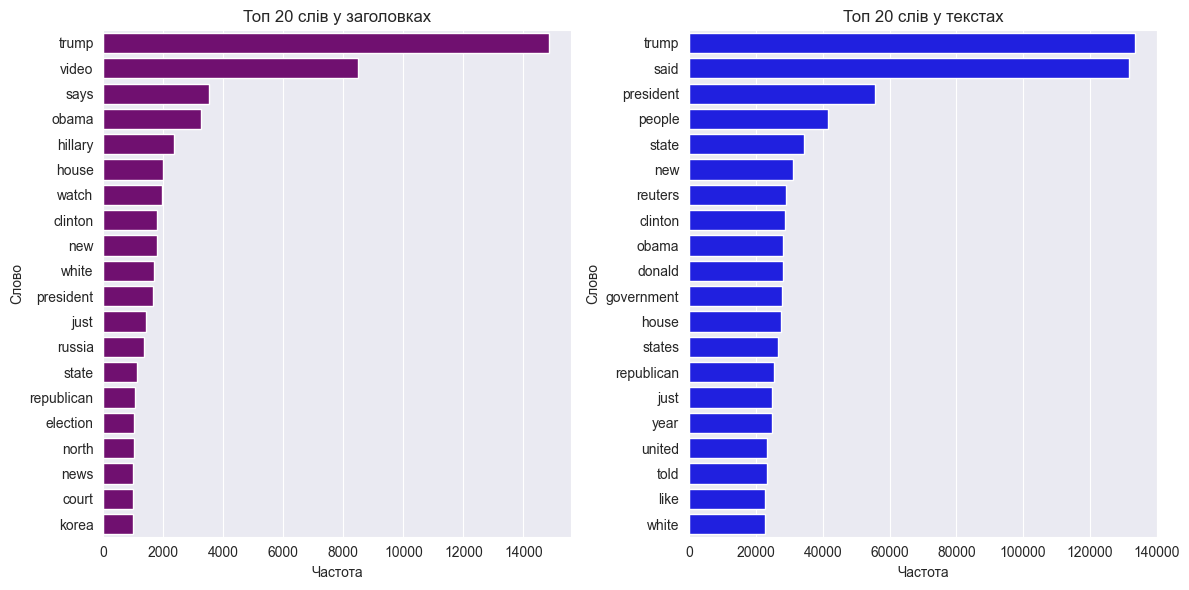

In [21]:
vectorizer_title = CountVectorizer(stop_words='english', max_features=20)
X_title = vectorizer_title.fit_transform(df['title'])
title_word_counts = X_title.toarray().sum(axis=0)
top_words_title = vectorizer_title.get_feature_names_out()

vectorizer_text = CountVectorizer(stop_words='english', max_features=20)
X_text = vectorizer_text.fit_transform(df['text'])
text_word_counts = X_text.toarray().sum(axis=0)
top_words_text = vectorizer_text.get_feature_names_out()

sorted_title_words = [x for _, x in sorted(zip(title_word_counts, top_words_title), reverse=True)]
sorted_title_counts = sorted(title_word_counts, reverse=True)

sorted_text_words = [x for _, x in sorted(zip(text_word_counts, top_words_text), reverse=True)]
sorted_text_counts = sorted(text_word_counts, reverse=True)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.barplot(x=sorted_title_counts, y=sorted_title_words, color='purple')
plt.title('Топ 20 слів у заголовках')
plt.xlabel('Частота')
plt.ylabel('Слово')

plt.subplot(1, 2, 2)
sns.barplot(x=sorted_text_counts, y=sorted_text_words, color='blue')
plt.title('Топ 20 слів у текстах')
plt.xlabel('Частота')
plt.ylabel('Слово')

plt.tight_layout()

Спостереження:

Заголовки:
- Абсолютним лідером є слово trump, з істотною перевагою.
- Інші часті слова мають інформаційний або емоційний характер.
- Багато слів мають політичну тематику також зустрічаються прізвища політиків.

Тексти:
- Переважають формальні, нейтральні лексеми.
- Присутні також імена/прізвища політиків.


Проаналізуємо топ-20 слів що зустрічаються в фейкових та реальних новинах:

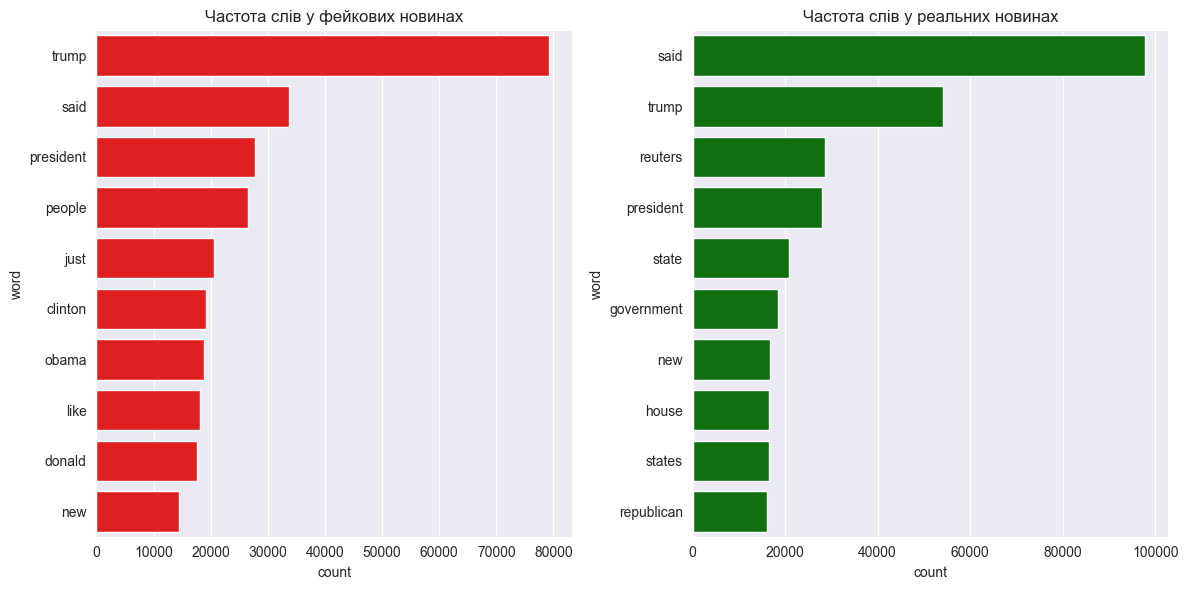

In [22]:
vectorizer = CountVectorizer(stop_words='english', max_features=20)
X = vectorizer.fit_transform(df['text'])

X_array = X.toarray()

fake_mask = df['is_fake'] == 1
fake_words = X_array[fake_mask].sum(axis=0)
fake_top_words = heapq.nlargest(10, zip(vectorizer.get_feature_names_out(), fake_words), key=lambda x: x[1])

real_mask = df['is_fake'] == 0
real_words = X_array[real_mask].sum(axis=0)
real_top_words = heapq.nlargest(10, zip(vectorizer.get_feature_names_out(), real_words), key=lambda x: x[1])

fake_df = pd.DataFrame(fake_top_words, columns=['word', 'count'])
real_df = pd.DataFrame(real_top_words, columns=['word', 'count'])

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.barplot(x='count', y='word', data=fake_df, color='red')
plt.title('Частота слів у фейкових новинах')

plt.subplot(1, 2, 2)
sns.barplot(x='count', y='word', data=real_df, color='green')
plt.title('Частота слів у реальних новинах')

plt.tight_layout()
plt.show()


Спостереження:

Фейкові новини:
- Знову бачимо слово trump - лідер серед фейкових новин та на другому місці серед реальних.
- Багато слів пов'язані з персонами та емоційною лексикою, наприклад:
    - just, like, people — можуть сигналізувати про більш суб’єктивну манеру викладення.
- Басимо також багато слів, що прізвищами політиків: clinton, obama, donald.

Реальні новини:
- Найчастіше вживається слово said - що дає нам можливість припустити, що це було цитування.
- Часто зустрічаються: trump, reuters, president, state, government, new, house, states, republican.
- Більше переважають офіційні терміни: government, state, reuters, president, republican.

Узагальнюючи можемо сказати, що у фейкових новинах домінують персональні імена та емоційно забарвлена лексика, що може вказувати на маніпулятивну чи суб’єктивну подачу інформації. Справжні новини більш структуровані, з переважанням репортажних формулювань і посиланнями на офіційні джерела (said, reuters, government).

### Проаналізуємо кількість унікальних слів

In [23]:
def get_vocab_size(series):
    vectorizer = CountVectorizer(stop_words='english')
    vectorizer.fit(series.astype(str))
    return len(vectorizer.vocabulary_)

vocab_all = get_vocab_size(df["text"])
vocab_fake = get_vocab_size(df[df["is_fake"] == 1]["text"])
vocab_real = get_vocab_size(df[df["is_fake"] == 0]["text"])

print(f"Унікальні слова (всі новини): {vocab_all}")
print(f"Унікальні слова (фейкові): {vocab_fake}")
print(f"Унікальні слова (справжні): {vocab_real}")

Унікальні слова (всі новини): 121686
Унікальні слова (фейкові): 94136
Унікальні слова (справжні): 66361


Спостереження:

- Фейкові новини мають більше унікальних слів, ніж справжні. Це свідчить про вищу лексичну варіативність у фейковому контенті. Можливо, автори фейкових новин використовують більше різноманітної лексики — для імітації достовірності, впливу на емоції читача, або створення ефекту новизни.
- Справжні новини, ймовірно, використовують більш стандартизовану лексику, що притаманна класичному журналістському стилю.

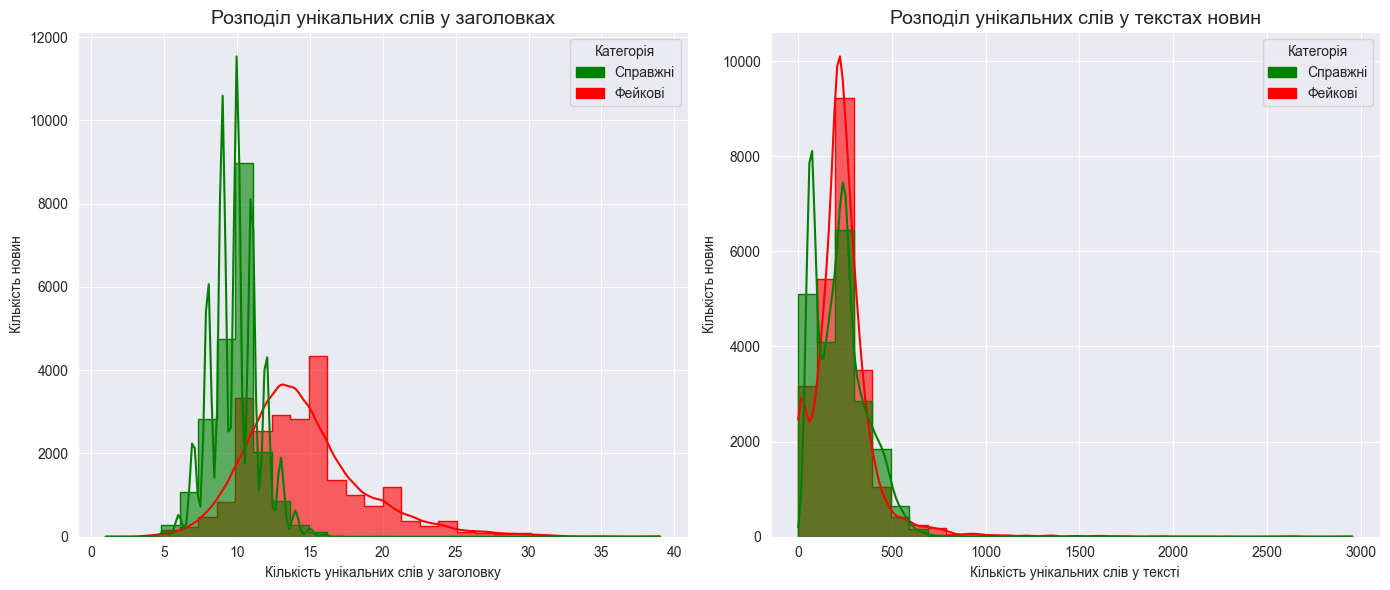

In [24]:
def unique_words(text):
    return len(set(text.split()))

df["unique_words_title"] = df["title"].apply(unique_words)
df["unique_words_text"] = df["text"].apply(unique_words)
plt.figure(figsize=(14, 6))

palette = {0: 'green', 1: 'red'}

plt.subplot(1, 2, 1)
sns.histplot(data=df, x='unique_words_title', hue='is_fake', bins=30, kde=True,
             palette=palette, element='step', alpha=0.6)
plt.title('Розподіл унікальних слів у заголовках', fontsize=14)
plt.xlabel('Кількість унікальних слів у заголовку')
plt.ylabel('Кількість новин')
plt.grid(True)

handles = [mpatches.Patch(color='green', label='Справжні'),
           mpatches.Patch(color='red', label='Фейкові')]
plt.legend(handles=handles, title='Категорія')

plt.subplot(1, 2, 2)
sns.histplot(data=df, x='unique_words_text', hue='is_fake', bins=30, kde=True,
             palette=palette, element='step', alpha=0.6)
plt.title('Розподіл унікальних слів у текстах новин', fontsize=14)
plt.xlabel('Кількість унікальних слів у тексті')
plt.ylabel('Кількість новин')
plt.grid(True)
plt.legend(handles=handles, title='Категорія')

plt.tight_layout()
plt.show()


Спостереження:

Заголовки:
- У справжніх новин більшість заголовків містить 8–12 унікальних слів.
- У фейкових заголовках розподіл зміщений вправо: частіше містять 13–20 унікальних слів.

Можемо припускати, що тут має місце прагнення до більш складних або гучних заголовків у фейковому контенті.

Тексти:
- Розподіл для обох класів сильно асиметричний, зі зміщенням у бік коротших текстів.
- Фейкові новини демонструють трохи більшу кількість унікальних слів, особливо у середньому діапазоні, коли тексти справжніх новин мають менший розкид, що вказує на більш стандартизовану структуру.

Отже, можемо припускати, що унікальні слова інформативна ознака, яка може сигналізувати про стиль, глибину та намір автора.Фейкові новини зазвичай містять більше унікальних слів.

Подивимось тепер на біграми.

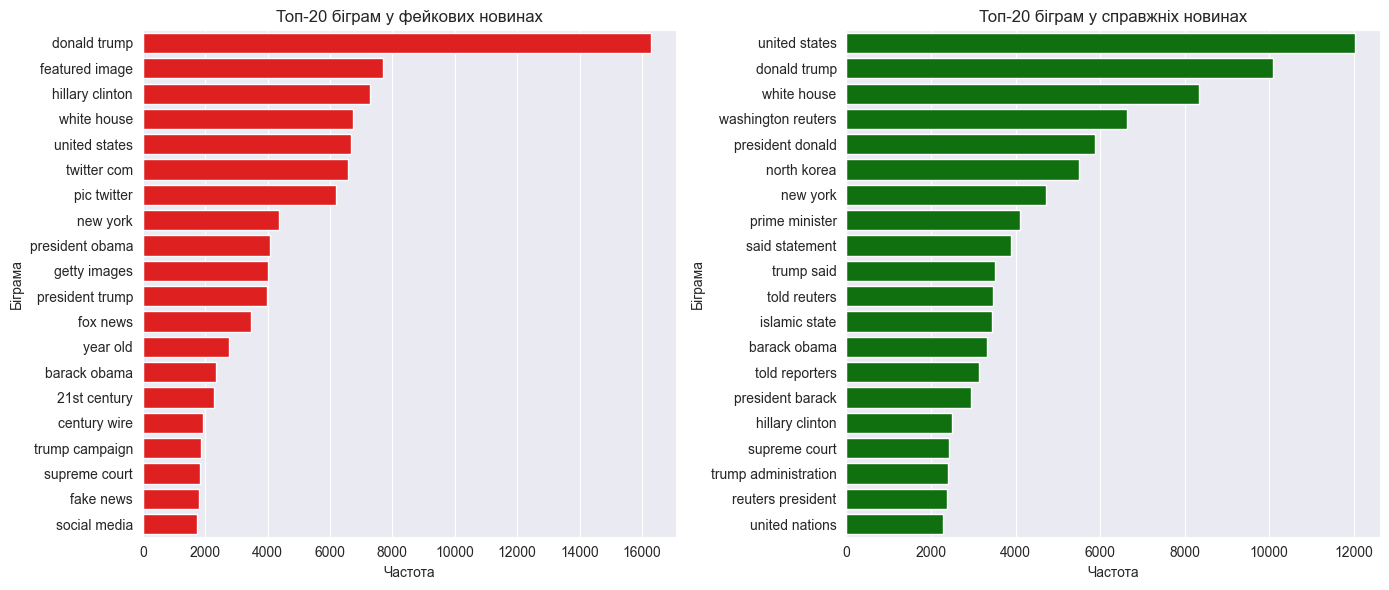

In [25]:
def get_top_ngrams(texts, ngram_range=(2, 2), top_n=20):
    vectorizer = CountVectorizer(stop_words='english', ngram_range=ngram_range)
    X = vectorizer.fit_transform(texts)
    sum_words = X.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return pd.DataFrame(words_freq[:top_n], columns=["bigram", "count"])

bigrams_fake = get_top_ngrams(df[df['is_fake'] == 1]['text'], top_n=20)
bigrams_real = get_top_ngrams(df[df['is_fake'] == 0]['text'], top_n=20)

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.barplot(data=bigrams_fake, x="count", y="bigram", color='red')
plt.title("Топ-20 біграм у фейкових новинах")
plt.xlabel("Частота")
plt.ylabel("Біграма")

plt.subplot(1, 2, 2)
sns.barplot(data=bigrams_real, x="count", y="bigram", color='green')
plt.title("Топ-20 біграм у справжніх новинах")
plt.xlabel("Частота")
plt.ylabel("Біграма")

plt.tight_layout()
plt.show()


Спостереження:

Бачимо часті особові зв’язки: donald trump, hillary clinton, president obama, barack obama, president trump у фейкових новинахУ справжніх новинах знову бачимо багато офіційних формулювань на політичну тему: united states, white house, north korea, prime minister, united nations, як і згадки державних органів та посад: supreme court, trump administration, president donald, government officials.

Можемо припускати, що справжні новини дотримуються формального стилю подачі та часто згадують джерела інформації.






## Продивимось дати публікацій новин

In [26]:
df = process_date(df)
df.head(5)

Removed 1 rows


,Unnamed: 0,title,text,date,is_fake,title_length,text_length,text_tokens,text_length_tokens,title_tokens,title_length_tokens,unique_words_title,unique_words_text,date_parsed
0,0,Earthquake hits off Papua New Guinea,LONDON (Reuters) - A magnitude 5.9 earthquake ...,"September 17, 2017",0,36,305,"[london, a, magnitude, 59, earthquake, hit, of...",53,"[earthquake, hits, off, papua, new, guinea]",6,6,47,2017-09-17
1,1,CINDY MCCAIN Reportedly Accepts Trump Administ...,The Hill released controversial comments sore ...,"Jun 12, 2017",1,149,1859,"[the, hill, released, controversial, comments,...",288,"[cindy, mccain, reportedly, accepts, trump, ad...",20,19,176,2017-06-12
2,2,Prosecutors say ex-House Speaker Hastert sexua...,(Reuters) - Former U.S. House Speaker Dennis H...,"April 9, 2016",0,61,1995,"[former, us, house, speaker, dennis, hastert, ...",329,"[prosecutors, say, exhouse, speaker, hastert, ...",8,8,198,2016-04-09
3,3,Romanian protesters halt building of Xmas fair...,BUCHAREST (Reuters) - Romanian protesters clas...,"December 2, 2017",0,62,2082,"[bucharest, romanian, protesters, clashed, wit...",324,"[romanian, protesters, halt, building, of, xma...",10,10,211,2017-12-02
4,4,"Congo elected to U.N. rights council; Britain,...",UNITED NATIONS (Reuters) - Democratic Republic...,"October 16, 2017",0,59,2513,"[united, nations, democratic, republic, of, co...",395,"[congo, elected, to, un, rights, council, brit...",9,9,245,2017-10-16


In [27]:
print("Діапазон дат:", df['date_parsed'].min(), "-", df['date_parsed'].max())
print("Кількість унікальних дат:", df['date_parsed'].nunique())

Діапазон дат: 2015-03-31 00:00:00 - 2018-02-19 00:00:00
Кількість унікальних дат: 1010


Бачимо, що новини охоплюють період перед та після виборів у США (2016) — можливий сплеск фейкових публікацій.

In [28]:
df.loc[:, 'year_month'] = df['date_parsed'].dt.to_period('M')
df_monthly_counts = df.groupby(['year_month', 'is_fake']).size().unstack(fill_value=0)

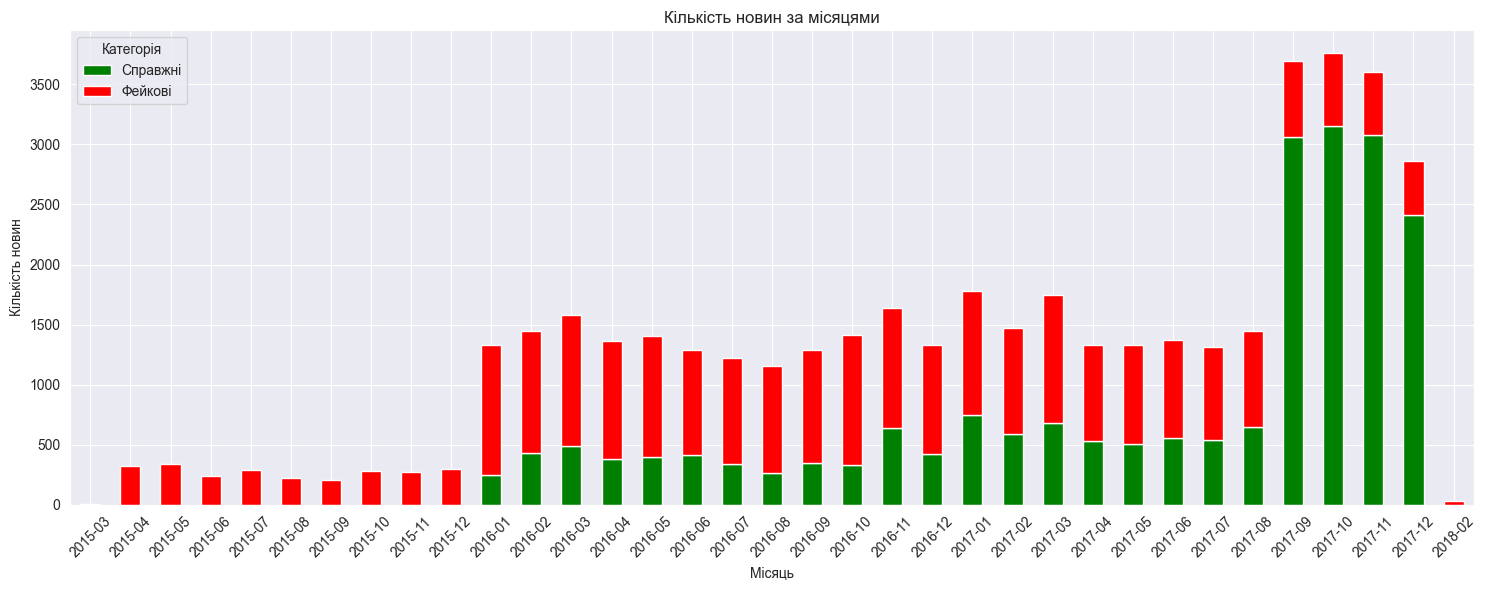

In [29]:
df_monthly_counts.plot(kind='bar', stacked=True, figsize=(15, 6), color=['green', 'red'])
plt.title('Кількість новин за місяцями')
plt.ylabel('Кількість новин')
plt.xlabel('Місяць')
plt.xticks(rotation=45)
plt.legend(title='Категорія', labels=['Справжні', 'Фейкові'])
plt.tight_layout()
plt.show()

Спостереження:
- З візуалізації бачимо, що до початку 2016 року новини були ймовірно майже повністю фейкові, і загальна активність була помірною.
- З 2016 року спостерігається поява справжніх новин, і поступове зростання кількості публікацій обох типів.
- Пік активності припадає на кінець 2017 року, де кількість справжніх новин різко перевищує кількість фейкових.
- З 2017-9 спостерігається рекордне зростання загальної кількості новин.

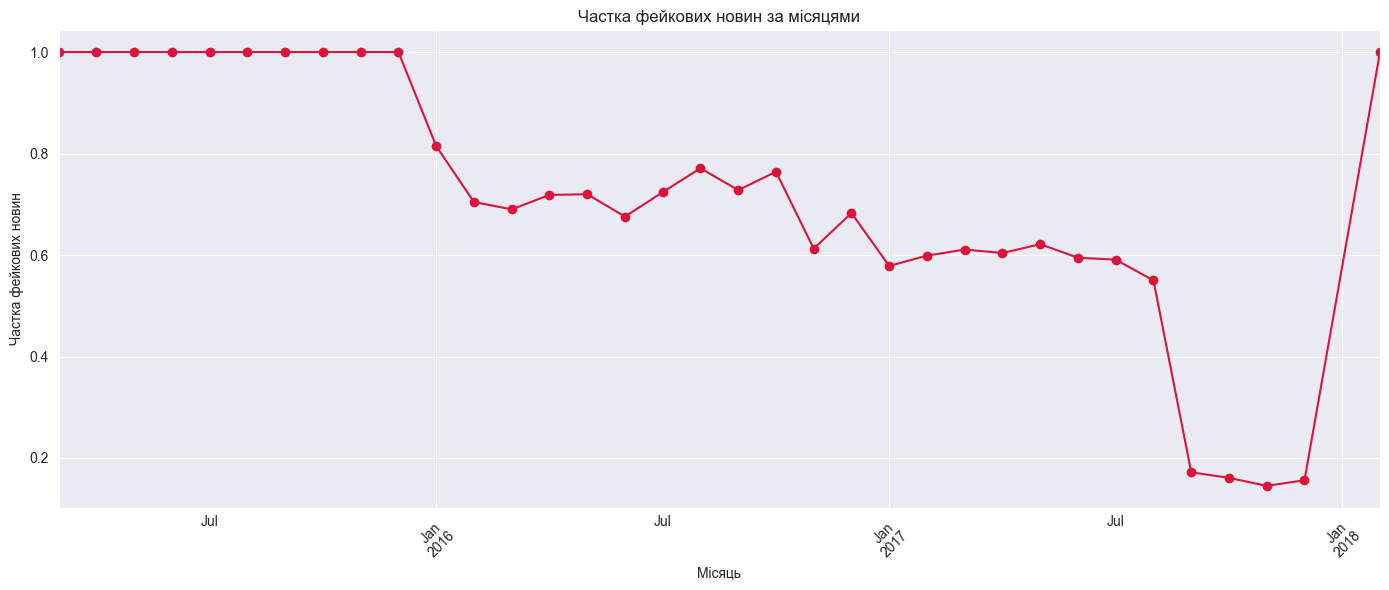

In [30]:
monthly_counts = df.groupby(['year_month', 'is_fake']).size().unstack(fill_value=0)
monthly_counts['fake_ratio'] = monthly_counts[1] / (monthly_counts[0] + monthly_counts[1])

plt.figure(figsize=(14, 6))
monthly_counts['fake_ratio'].plot(marker='o', color='crimson')
plt.title('Частка фейкових новин за місяцями')
plt.ylabel('Частка фейкових новин')
plt.xlabel('Місяць')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


Спостереження:
- У 2015 році фейкові новини переважали повністю — частка тримається на рівні 1.0.
- З початку 2016 року — чітке зниження частки фейкових новин: вона падає до 80%, потім 65–70%.
- Протягом 2016–2017 років спостерігається хвилеподібне коливання частки фейкових новин у діапазоні 65–70%.
- Починаючи з серпня-вересня 2017 року — різкий спад до ~15% і утримання на цьому рівні до кінця року. Пам'ятаємо, що у цей період спостерігали збільшення публікацій новин.
- Бачимо сплеск у 2018 року, але він пов'язаний щ тим, що у нас мало даних за 2018 рік.

Подивимось тепер на відношення фейкових до справжніх новин у часі

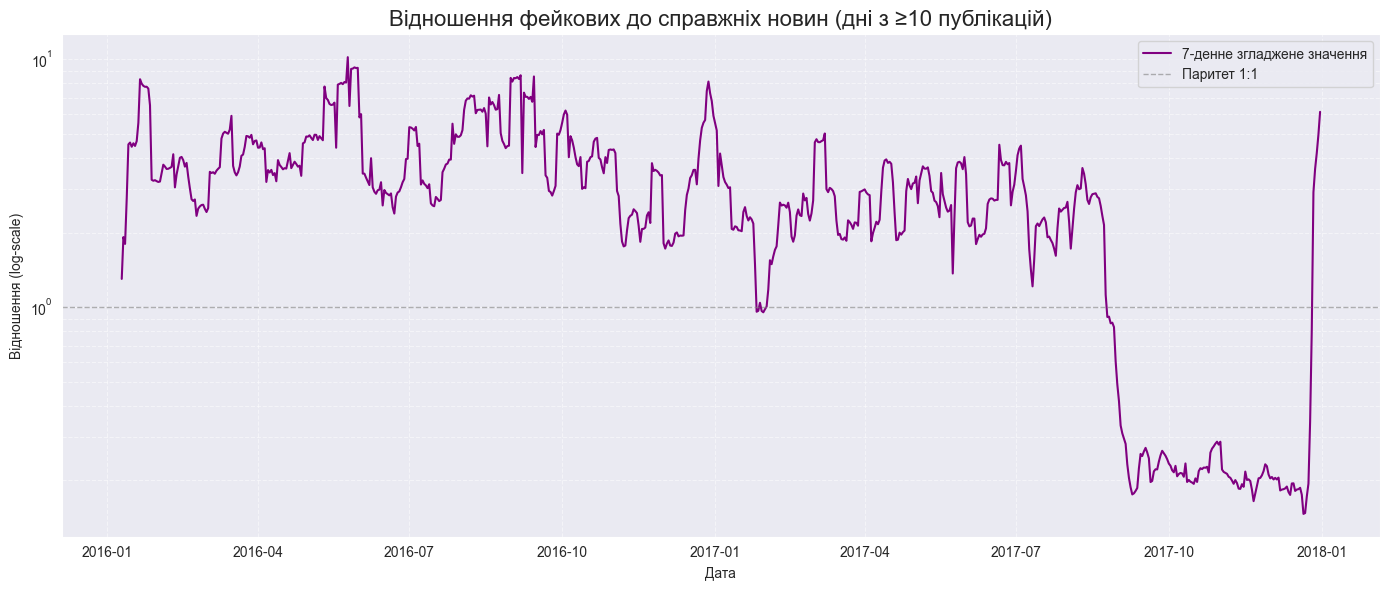

In [31]:
day_counts = df.groupby(['date_parsed', 'is_fake']).size().reset_index(name='count')

fake_counts = day_counts[day_counts['is_fake'] == 1].rename(columns={'count': 'fake_count'})
real_counts = day_counts[day_counts['is_fake'] == 0].rename(columns={'count': 'real_count'})

merged = pd.merge(fake_counts[['date_parsed', 'fake_count']],
                  real_counts[['date_parsed', 'real_count']],
                  on='date_parsed', how='outer')

merged[['fake_count', 'real_count']] = merged[['fake_count', 'real_count']].fillna(0)
merged['total_count'] = merged['fake_count'] + merged['real_count']
merged = merged[merged['total_count'] >= 10]
merged['fake_to_real_ratio'] = merged['fake_count'] / merged['real_count'].replace(0, np.nan)
merged['smoothed_ratio'] = merged['fake_to_real_ratio'].rolling(window=7, center=True, min_periods=1).mean()

plt.figure(figsize=(14, 6))
sns.lineplot(x='date_parsed', y='smoothed_ratio', data=merged, color='purple', label='7-денне згладжене значення')
plt.title('Відношення фейкових до справжніх новин (дні з ≥10 публікацій)', fontsize=16)
plt.xlabel('Дата')
plt.ylabel('Відношення (log-scale)')
plt.yscale('log')
plt.axhline(1, color='gray', linestyle='--', linewidth=1, alpha=0.6, label='Паритет 1:1')
plt.legend()
plt.grid(True, which='both', ls='--', alpha=0.5)
plt.tight_layout()
plt.show()


Спостереження:
На візуалізації зображено, як змінювалося відношення кількості фейкових новин до справжніх у кожен день, для тих дат, де сумарно було не менше 10 новин. Це дозволяє уникнути шуму від днів з малою активністю.
Крива відображає 7-денне згладжене значення, а вертикальна шкала є логарифмічною (log-scale), що дає змогу краще побачити тренди на різних масштабах.


- У період 2016–2017 років, фейкові новини переважали більшість днів
- Починаючи з серпня–вересня 2017 року, спостерігається різке зниження відношення, тобто справжніх новин стало більше.
- У кінці 2017 року графік стає стабільно нижчим за 1, що говорить про перехід у домінування реального контенту.
- Різке підвищення в січні 2018 року може бути пов’язане з малою кількістю реальних новин у ті дні або неповними даними.

Оскільки маємо припущення, з візуалізацій вище, про відсутність даних за певні періоди (особливо ближче до кінця 2017 — початку 2018 року), кількість новин у наборі могла бути значно меншою, або дані були неповними.
Щоб перевірити цю гіпотезу, а також оцінити темпи накопичення фейкових та справжніх новин, побудуємо кумулятивну криву — тобто сумарну кількість новин для кожного класу у часі.

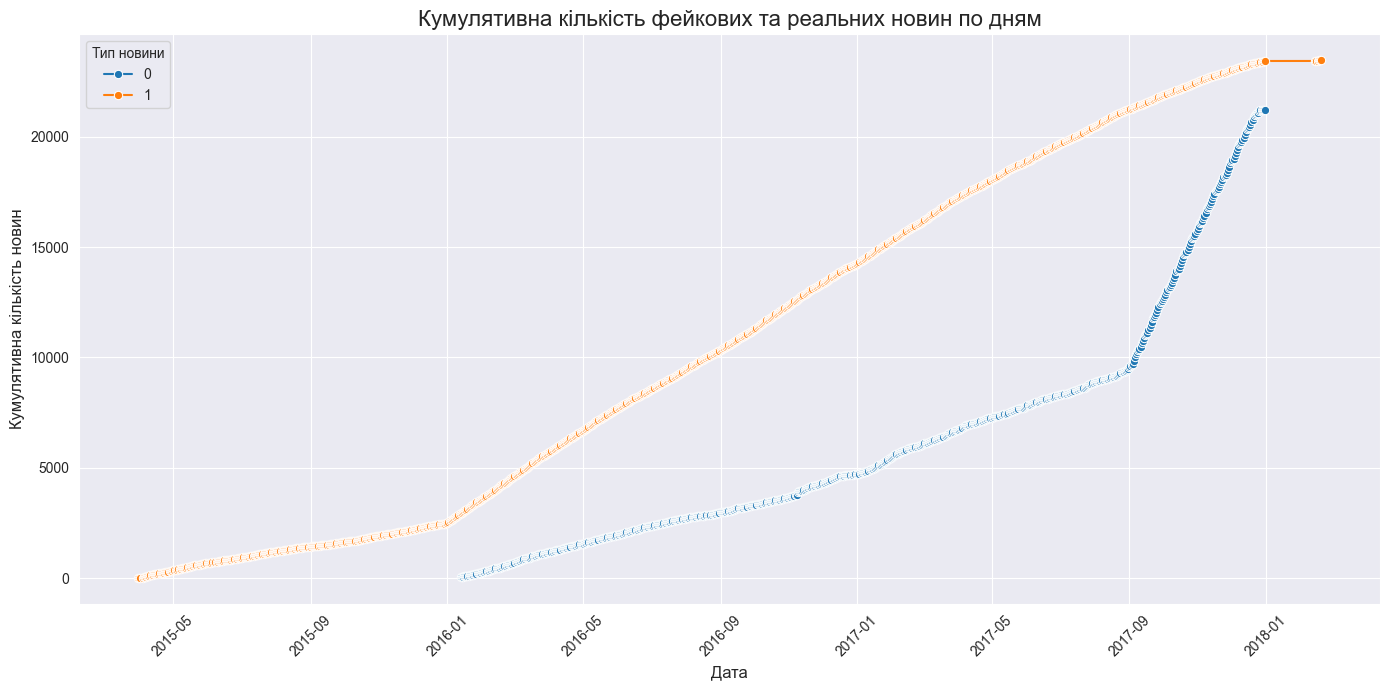

In [32]:
day_counts = df.groupby(['date_parsed', 'is_fake']).size().reset_index(name='count')
day_counts['cumulative_count'] = day_counts.groupby('is_fake')['count'].cumsum()

plt.figure(figsize=(14, 7))
sns.lineplot(x='date_parsed', y='cumulative_count', hue='is_fake', data=day_counts, marker='o')
plt.title('Кумулятивна кількість фейкових та реальних новин по дням', fontsize=16)
plt.xlabel('Дата', fontsize=12)
plt.ylabel('Кумулятивна кількість новин', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title='Тип новини')
plt.grid(True)
plt.tight_layout()
plt.show()


Спостереження:

Отже, на даному графіку можемо бачити, як швидко збирались новини кожного типу.
- Бачимо, що справжні новини починають активно зростати лише з 2016 року, а найрізкіший приріст спостерігається в другій половині 2017 року.
- Цей графік підтверджує гіпотезу, що у ранні періоди (2015–2016) датасет складався переважно з фейкових новин. Значна частина справжніх новин була додана пізніше, можливо як спроба збалансувати корпус. Справжні новини були зібрані набагато інтенсивніше в 2017 році, що відповідає різкому зростанню їх частки на попередньому графіку.



## Аналіз токенів

In [33]:
df.loc[:, "all_text"] = df['title'] + ' ' + df['text']
df["processed_tokens"] = df['all_text'].apply(process_text)
all_tokens = df["processed_tokens"].dropna().tolist()
flat_tokens = [token for sublist in all_tokens for token in sublist if token]

In [34]:
analyzer = TokenFrequencyAnalyzer(flat_tokens)
token_analyzed = analyzer.to_dataframe()

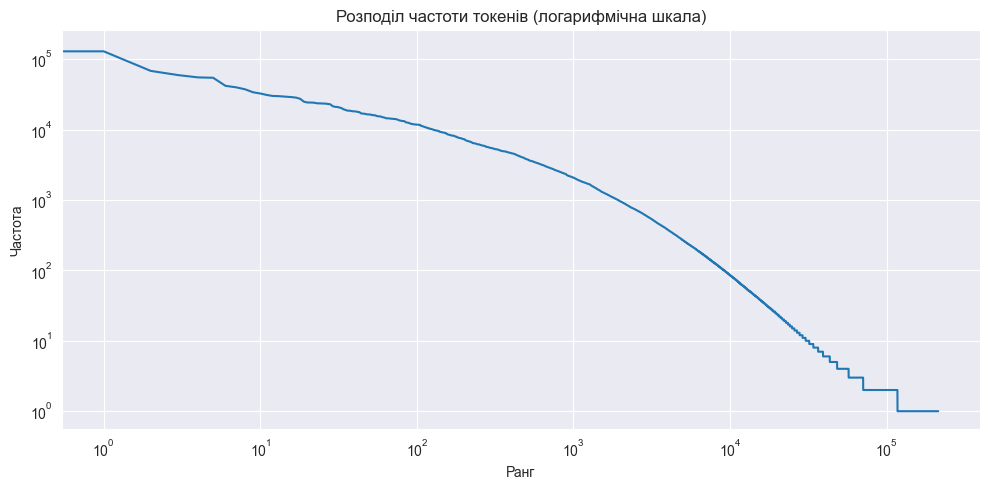

In [35]:
analyzer.plot_distribution(loglog=True)

Спостереження:
- Спостерігається майже горизонтальне плато для рангів 1-10, що вказує на дуже часті токени.
- Бачимо плавний спад для рангів 10-1000. На цій ділянці крива знижується більш поступово, ніж далі, отже це може свідчити про токени середньої частотності.
- Після рангу 1000 крива починає більш стрімко знижуватися, частота значно падає, що може бути ознакою рідковживаних слів.




Можемо відкинути довгий “хвіст” малочастотних токенів, щоби зменшити розмірність вектора та шум.
Для baseline моделі встановимо min_df=3, щоб відкинути найрідкісніші слова, а встановлення max_features=4000 — дозволить зберегти найінформативнішу частину словника.

### Загальний висновок

- В ході проведення аналізу ми можемо бачити, що фейкові та реальні новини мають різну структуру. Зазвичай заголовки для фейкових новин є довшими і довжини їх текстів також мають більший розкид. Фейкові новини також мають більшу унікальність слів, що можливо може вказувати на те, що автори навмисно застосовують такий підхід, щоб створити у читача враження унікальності і правдивості тексту.

- Було виявлено, що новини містять багато слів політичної тематики, включаючи імена політиків. Справжні новини часто мають формальні структури, і складається враження відповідності найбільш вживаних слів офіційному стилю.

- Попри те, що вибірка є достатньо забалансованою, ми не маємо правдивих новин за деякі періоди часу. Так, наприклад, до 2016 року вибірка містить лише фейкові новини, а під кінець 2017 року у нас спостерігається різке збільшення новин.

